delete this cell before submitting for review

> * test on both environments
As of September 2019, the `DEA Sandbox` has a single year of continental Landsat data for 2015-16, and the full 1987-onward time-series for three locations (Perth WA, Brisbane QLD, and western NSW).

> * When writing in Markdown cells, start each sentence on a **new line**.
This makes it easy to see changes through git commits.
> * Use Australian English in markdown cells and code comments.
> * Check the [known issues](https://github.com/GeoscienceAustralia/dea-docs/wiki/Known-issues) for formatting regarding the conversion of notebooks to DEA docs using Sphinx.
Things to be aware of:
    * Sphinx is highly sensitive to bulleted lists:
        * Ensure that there is an empty line between any preceding text and the list
        * Only use the `*` bullet (`-` is not recognised)
        * Sublists must be indented by 4 spaces
    * Two kinds of formatting cannot be used simultaneously:
        * Hyperlinked code: \[\`code_format\`](hyperlink) fails
        * Bolded code: \*\*\`code_format\`\*\* fails
    * Headers must appear in hierachical order (`#`, `##`, `###`, `####`) and there can only be one title (`#`).
> * Use the [PEP8 standard](https://www.python.org/dev/peps/pep-0008/) for code. To make sure all code in the notebook is consistent, you can use the `jupyterlab_code_formatter` tool: select each code cell, then click `Edit` and then one of the `Apply X Formatter` options (`YAPF` or `Black` are recommended). This will reformat the code in the cell to a consistent style.

> * In the final notebook cell, include a set of relevant tags which are used to build the DEA User Guide's [Tag Index](https://docs.dea.ga.gov.au/genindex.html). 
Use all lower-case (unless the tag is an acronym), separate words with spaces (unless it is the name of an imported module), and [re-use existing tags](https://github.com/GeoscienceAustralia/dea-notebooks/wiki/List-of-tags).
Ensure the tags cell below is in `Raw` format, rather than `Markdown` or `Code`.

> * The DEA Image placed in the title cell will display as long as the notebook is contained in one of the standard directories.
It does not work in the highest level directory (hence why it doesn't display in the original template notebook).
> * In the final notebook cell, include a set of relevant tags which are used to build the DEA User Guide's [Tag Index](https://docs.dea.ga.gov.au/genindex.html). 
Use all lower-case (unless the tag is an acronym), separate words with spaces (unless it is the name of an imported module), and [re-use existing tags](https://github.com/GeoscienceAustralia/dea-notebooks/wiki/List-of-tags).
Ensure the tags cell below is in `Raw` format, rather than `Markdown` or `Code`.


Before pushing this:
    * delete general advice cell 
    * go thru general advice cell
    * check packages
    * move scripts directory
    * move this notebook to frequently used code
    

# Polygonising pixel edges <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI`|`DEA Sandbox` environment only
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule)

## Background
The ability to get the pixel boundaries as a shapefile or other vector file type is very useful for remote sensing applications where the boundaries of the pixel are needed. This is useful for cases such as matching drone imagery with remotely sensed imagery. 


## Description
This notebook uses Digital Earth Australia to retrieve satellite data, creates a vector file from the pixel boundaries of the data, and exports to file.

1. First we load some data for a chosen time frame using the dea-notebooks `load_ard` function
2. Then we convert our raster data into a polygon per pixel
3. Then we export our pixel edges polygons as a vector file (shapefile)
4. This loop is repeated twice (once for Sentinel 2 data and once for Landsat data)

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [1]:
%matplotlib notebook
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import rasterio.features
from shapely.geometry import shape
import sys
import xarray as xr

# Point this to where you have the algorithms from the dea-notebooks/algorithms saved
sys.path.append(os.path.abspath('../../Scripts'))
from dea_datahandling import load_ard

sys.path.append('../Scripts')
from dea_plotting import rgb
from odc.ui import with_ui_cbk

#chessboard notebook
%matplotlib inline
from datacube.helpers import write_geotiff
from datacube.utils import masking
from datacube import Datacube
from datetime import datetime

%load_ext autoreload
%autoreload 2

### Define useful functions
The function below is a helper function to help you make a nice filename for the output files

In [23]:
def create_filename(ds, image_index, query, prefix=''):
    '''create_filename is a handy function to turn your xarray dataset and image number into a nice output filename for your shapefile.
    ds : an xarray dataset
    image_index : an integer value between 0 and however many images you have
    prefix : a string : an optional name prefix to identify your area of interest'''
    assert ds
    image_date = str(ds.nbart_red[image_index].time.data)[:10]
    image_coords = f"{query['x'][0]}_{query['y'][0]}_{query['x'][1]}_{query['y'][1]}"
    if prefix:
        output_name=f"{str(prefix)}_{image_date}_{image_coords}"
    else:
        output_name=f"{image_date}_{image_coords}"
        print(output_name)
    return output_name

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = Datacube(app='Polygonise pixel edges')

## Analysis parameters
* `x` : a tuple of longitude/Easting boundaries defining the area of interest in the format (smaller, larger) e.g. `(153.40, 153.50)`
* `y` : a tuple of latitude/Northing boundaries defining the area of interest in the format (smaller, larger) e.g. `(-27.40, -27.50)`
* `time` : a tuple of time values in a pandas datetime format defining the time period of interest in the format (smaller, larger) e.g. `("2018-08-01", "2018-08-20")`
* `products` : A list of product names to load from the datacube e.g. `['ga_ls7e_ard_3', 'ga_ls8c_ard_3']`
* `measurements` : A list of band names to load from the satellite product e.g. `['nbart_red', 'nbart_green']`
* `resolution` : The spatial resolution of the loaded satellite data e.g. for Landsat, this is `(-30, 30)`
* `output_crs` : The coordinate reference system/map projection to load data into, e.g. `'EPSG:3577'` to load data in the Albers Equal Area projection
* `align` : How to align the x, y coordinates respect to each pixel e.g. Landsat Collection 3 should be centre aligned `(15, 15)` 
* `group_by` : How to group the data e.g. `"solar_day"`

## Set up a datacube query for our area of interest
Grab Sentinel2 satellite data first

In [4]:
# Create a query object
s2_query = {
    'x': (153.40, 153.50),
    'y': (-27.40, -27.50),
    "time": ("2018-08-01", "2018-08-20"),
    "products": ("s2a_ard_granule", "s2b_ard_granule"),
    "measurements": ["nbart_red","nbart_green", "nbart_blue", "fmask"],
    "output_crs": "EPSG:3577",
    "resolution": (-10, 10),
    "group_by": "solar_day",
}

Load available data from Sentinel2 satellites

In [18]:
# Load sentinel2 data using load_ard. We're not using fmask to mask our pixel quality, as we're after the surrounds of the pixels not big white blobs.
s2_ds = load_ard(dc=dc, 
              min_gooddata=0.95, #only take scenes with less than 5% fmask activations
              mask_pixel_quality=False,
              **s2_query)

Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step
Filtering to 4 out of 8 time steps with at least 95.0% good quality pixels
Loading 4 time steps


### Plot up some data to take a look at it

Use the `rgb` function from `dea-plotting` module to look at our area of interest in true colour

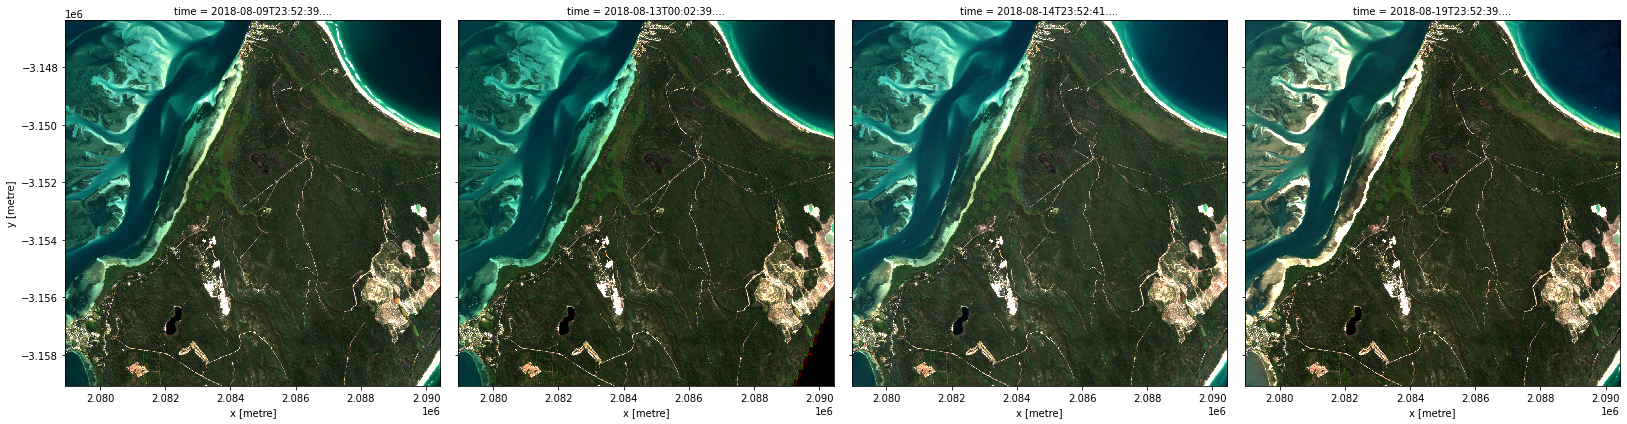

In [19]:
rgb(s2_ds, bands = ['nbart_red','nbart_green','nbart_blue'], col='time')

## Choose an image index to use to polygonise the pixels
Change the number in the cell below to select a different image from the images in the previous cell; 0 is the first image.

In [26]:
image_index = 0

## Segment our image into per-pixel-polygons
Use the red band to create a polygon for each pixel. 

In [21]:
# Input array to segment and vectorise
input_array = s2_ds.nbart_red[image_index]
input_transform = s2_ds.affine #(30, 0, 0, 0, -30, 0)  # replace with xarray transform
input_crs = s2_ds.crs

# Create array with a unique value per cell
unique_pixels = np.arange(input_array.size).reshape(input_array.shape)

# Vectorise each unique feature in array
vectors = rasterio.features.shapes(source=unique_pixels.astype(np.int16), 
                                     transform=input_transform)

# Extract polygons and values from generator
vectors = list(vectors)
values = [value for polygon, value in vectors]
polygons = [shape(polygon) for polygon, value in vectors]

# Create a geopandas dataframe populated with the polygon shapes
s2_poly_gdf = gpd.GeoDataFrame(data={'id': values},
                       geometry=polygons,
                       crs=input_crs)

## Investigate the results
Print and plot the first 5 entries in the polygon geodataframe 

In [28]:
#print the first 5 rows in the geodataframe
s2_poly_gdf.head()

,id,geometry
0,0.0,"POLYGON ((2078930.000 -3146370.000, 2078930.00..."
1,1.0,"POLYGON ((2078940.000 -3146370.000, 2078940.00..."
2,2.0,"POLYGON ((2078950.000 -3146370.000, 2078950.00..."
3,3.0,"POLYGON ((2078960.000 -3146370.000, 2078960.00..."
4,4.0,"POLYGON ((2078970.000 -3146370.000, 2078970.00..."


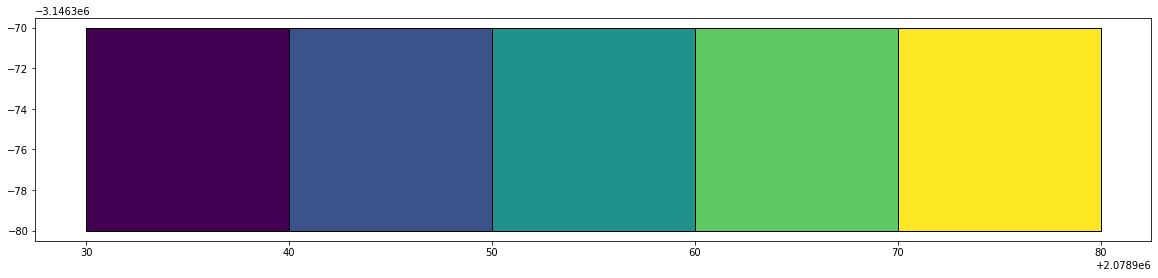

In [29]:
#plot the first five polygons in the geodataframe, coloured by id
s2_poly_gdf.head().plot(column='id', edgecolor='black', figsize=(20,20))
plt.show()

## Write our polygonised pixel edges for our area of interest out to file
Change the prefix in the cell below for a customised filename

In [24]:
output_filename = create_filename(s2_ds, image_index, s2_query, prefix = "NS_s2")

In [25]:
#write our new segmented shapefile out to a file
s2_poly_gdf.to_file(output_filename+'.shp')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** July 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)